In [ ]:
!pip install gensim # a useful NLP library that is used to load w2v embeddings

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings(action="ignore", category=UserWarning, module="gensim")
warnings.filterwarnings(action="ignore", category=FutureWarning, module="gensim")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<font color="00cec9">Load Data

In [ ]:
from google.colab import files
upload = files.upload()

Saving netflix.zip to netflix.zip


In [ ]:
!unzip netflix

Archive:  netflix.zip
  inflating: netflix_titles.csv      


<font color="00cec9">EDA

In [ ]:
df = pd.read_csv("netflix_titles.csv")

In [ ]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [ ]:
df['description'].count()

6234

In [ ]:
df['description'][0]

'Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.'

In [ ]:
df['title'][1000]

"All's Well, End's Well (2009)"

In [ ]:
df['description'][1000]

'Bound by a family rule that forbids him from marrying until his stubborn sister gets hitched, a bachelor enlists the help of a love guru to woo her.'

<font color="00cec9">only show columns of interest

In [ ]:
df2 = df[['title', 'description', 'listed_in']]
df2.head()

,title,description,listed_in
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies"
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV
3,Transformers: Robots in Disguise,When a prison ship crash unleashes hundreds of...,Kids' TV
4,#realityhigh,When nerdy high schooler Dani finally attracts...,Comedies


In [ ]:
df.type.unique()

array(['Movie', 'TV Show'], dtype=object)

<font color="00cec9">drop null values in description column

In [ ]:
df.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

<font color="00cec9">Visualizing the length of descriptions

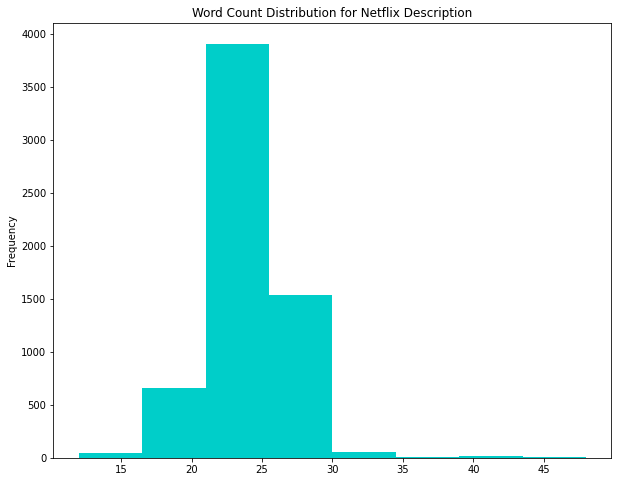

In [ ]:
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))
ax = df['word_count'].plot(
    kind='hist',
    bins=8,
    color='#00cec9',
    figsize=(10,8),
    title='Word Count Distribution for Netflix Description'
)

In [ ]:
df['description'] = df['description'].astype(str)

In [ ]:
# removing non-ascii characters
def non_ascii(s):
  return "".join(i for i in s if ord(i) < 128)

def lower(text):
  return text.lower()

#remove stopwords
def stop_words(text):
  text = text.split() # split tokens to find stop words
  stops = set(stopwords.words("english"))
  text = [w for w in text if not w in stops]
  text = " ".join(text)
  # join into a string after removing stop words
  return text

def clean_html(text):
  html = re.compile('<.*?>') # regex
  return html.sub(r'', text)

# remove punctuation
def punct(text):
  token = RegexpTokenizer(r'\w+') # regex
  text = token.tokenize(text)
  text = " ".join(text)
  return text

<font color="00cec9">Creating a Clean description column.

In [ ]:
df['new_desc'] = df['description'].apply(non_ascii)
df['new_desc'] = df.new_desc.apply(func = lower)
df['new_desc'] = df.new_desc.apply(func = stop_words)
df['new_desc'] = df.new_desc.apply(func = clean_html)
df['new_desc'] = df.new_desc.apply(func = punct)

<font color="turquoise">Creating the Model

In [ ]:
universe = [] # corpus
for words in df['new_desc']:
  universe.append(words.split()) # appends split-word(tokens) to the end of the list universe(corpus)

In [ ]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,word_count,new_desc
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,23,planning awesome wedding grandfather polar bea...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,25,jandino asporaat riffs challenges raising kids...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",23,help three human allies autobots protect earth...
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,20,prison ship crash unleashes hundreds deceptico...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,26,nerdy high schooler dani finally attracts inte...


<font color="yellow">Transfer Learning</font><br>
<font color="00cec9">using the word2vec pre-trained Google News model (GoogleNews-vectors-negative300) with the gensim Python Library.<br>
get GoogleNews pretrained data<br>
takes a few seconds to load in gensim

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-28 14:52:55--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  47.2MB/s    in 35s     

2021-12-28 14:53:30 (44.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



<font color="00cec9">embedding_file as the GoogleNews-vectors-negative300 file

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

<font color="00cec9">Training Corpus with Google Pretrained Model

In [ ]:
pretrained_model = Word2Vec(size=300, window=5, min_count=2, workers=-1)

# building a vocabulary
pretrained_model.build_vocab(universe)

# merging the input hidded weighted matrix, the intersect is where the original vector format 
# intersects with our current universe/corpus vocabulary
pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)
pretrained_model.train(universe, total_examples=pretrained_model.corpus_count, epochs=5)

(0, 0)

<font color="00cec9">Try out the similarity between words; after instersecting with our corpus-universe

In [ ]:
pretrained_model.wv.most_similar(positive=["prince"])
#parameter positive: gives a list of keys that contribute positively

[('princess', 0.6986509561538696),
 ('monarch', 0.668681263923645),
 ('royal', 0.6433806419372559),
 ('king', 0.6159993410110474),
 ('throne', 0.5817439556121826),
 ('palace', 0.5728127956390381),
 ('queen', 0.5534094572067261),
 ('nobleman', 0.5447623133659363),
 ('knight', 0.5390364527702332),
 ('kingdom', 0.5133712291717529)]

In [ ]:
pretrained_model.wv.most_similar(positive=["hand"])

[('hands', 0.6113166809082031),
 ('arm', 0.4354873597621918),
 ('thumb', 0.4265793561935425),
 ('handed', 0.4130321741104126),
 ('paw', 0.40222683548927307),
 ('fist', 0.395877480506897),
 ('side', 0.37118443846702576),
 ('cheek', 0.3695729672908783),
 ('chest', 0.3638487458229065),
 ('nose', 0.3625941276550293)]

In [ ]:
pretrained_model.wv.similarity("king", "queen")

0.6510957

In [ ]:
pretrained_model.wv.similarity("hand", "queen")

0.05110423

<font color="00cec9">The function Vectorize() defines the average word2vec for each Netflix description

In [ ]:
def vectorize(x):

  global embeddings
  # list to store the vectors; these are vectorized Netflix descriptions
  embeddings = []
  for line in df['new_desc']: 
    # for each cleaned description
    w2v = None
    count = 0
    for word in line.split():
      if word in pretrained_model.wv.vocab:
        count += 1
        if w2v is None:
          w2v = pretrained_model.wv[word]
        else:
          w2v = w2v + pretrained_model.wv[word]
    if w2v is not None:
      #append element to the end of the embeddings list
      w2v = w2v / count
      embeddings.append(w2v)

In [ ]:
def netflix_because_you_watched(title):
  vectorize(df)
  cosine_similarities = cosine_similarity(embeddings, embeddings)

  netflix_shows = df[['title']] # new dataframe with reversed indexes
  indices = pd.Series(df.index, index=df['title']).drop_duplicates()
  ix = indices[title]
  cosine_sim = list(enumerate(cosine_similarities[ix])) #enumerate adds a counter to an iterable object and returns it
  cosine_sim = sorted(cosine_sim, key=lambda x: x[1], reverse=True)
  cosine_sim = cosine_sim[1:6] # we want the top 5 similar netflix shows
  netflix_index = [i[0] for i in cosine_sim]
  watch_next = netflix_shows.iloc[netflix_index]
  for index, row in watch_next.iterrows():
    print(row['title']) # printing the 5 shows that the algorithm assumes are similar to the given title

<font color="yellow">Netflix Recommendations

In [ ]:
netflix_because_you_watched('Transformers Prime')

The Shannara Chronicles
Transformers: Robots in Disguise
Power Rangers: Megaforce
Westerplatte Resists
Naruto Shippûden the Movie: The Will of Fire


In [ ]:
netflix_because_you_watched('Friends')

Big Mouth
Hap and Leonard
LEGO Friends: The Power of Friendship
Single Ladies Senior
Workin' Moms


<font color="00cec9">Note: Large dataset will provide us with better and more appropriate results.